In [1]:
import modules as md 
import xarray as xr
xr.set_options(display_style='html')
import intake
import cftime
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import s3fs
%matplotlib inline

In [2]:
s3 = s3fs.S3FileSystem(key="K1CQ7M1DMTLUFK182APD", secret="3JuZAQm5I03jtpijCpHOdkAsJDNLNfZxBpM15Pi0", 
                       client_kwargs=dict(endpoint_url="https://rgw.met.no"))

In [3]:
cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(cat_url)
cat = col.search(source_id=['NorESM2-LM'], activity_id = ['CMIP'], experiment_id=['piControl'], table_id=['Ofx'], variable_id=['areacello'], member_id=['r1i1p1f1'])
cat.df

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,NCC,NorESM2-LM,piControl,r1i1p1f1,Ofx,areacello,gn,gs://cmip6/CMIP6/CMIP/NCC/NorESM2-LM/piControl...,NaN,20210118


In [4]:
ds_dict = cat.to_dataset_dict(zarr_kwargs={'use_cftime':True})


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [59]:
remote_files = 's3://escience2022/Ada/monthly/chlos_Omon_NorESM2-LM_historical_r1i1p1f1_gn_*.nc'
remote_files = s3.glob(remote_files)
rem_files=remote_files[10:][:4]
print(rem_files)
# Iterate through remote_files to create a fileset
fileset = [s3.open(file) for file in rem_files]

ds = xr.open_mfdataset(fileset, combine='by_coords')


['escience2022/Ada/monthly/chlos_Omon_NorESM2-LM_historical_r1i1p1f1_gn_195001-195912.nc', 'escience2022/Ada/monthly/chlos_Omon_NorESM2-LM_historical_r1i1p1f1_gn_196001-196912.nc', 'escience2022/Ada/monthly/chlos_Omon_NorESM2-LM_historical_r1i1p1f1_gn_197001-197912.nc', 'escience2022/Ada/monthly/chlos_Omon_NorESM2-LM_historical_r1i1p1f1_gn_198001-198912.nc']


In [60]:
def weighted_temporal_mean(ds, var):
    """
    weight by days in each month
    """
    # Determine the month length
    month_length = ds.time.dt.days_in_month

    # Calculate the weights
    wgts = month_length.groupby("time.year") / month_length.groupby("time.year").sum()

    # Make sure the weights in each year add up to 1
    np.testing.assert_allclose(wgts.groupby("time.year").sum(xr.ALL_DIMS), 1.0)

    # Subset our dataset for our variable
    obs = ds[var]

    # Setup our masking for nan values
    cond = obs.isnull()
    ones = xr.where(cond, 0.0, 1.0)

    # Calculate the numerator
    obs_sum = (obs * wgts).resample(time="AS").sum(dim="time")

    # Calculate the denominator
    ones_out = (ones * wgts).resample(time="AS").sum(dim="time")

    # Return the weighted average
    return obs_sum / ones_out

In [69]:
da=weighted_temporal_mean(ds, 'chlos')
aa=da.groupby("time.year").sum(dim='time')
bb=aa.isel(year = slice(None,30))

BSsst = bb.where((bb.latitude>=65.9) & (bb.latitude<=81.9) & (bb.longitude <= 68.6)  & (bb.longitude >= 16.6))

#BSsst.mean(dim='year').plot.contourf()
#aa=av.groupby("time.year").sum(dim='time')
#mean=aa.mean(dim='year')
#mean

BSsst

<xarray.DataArray (year: 30, j: 385, i: 360)>
dask.array<where, shape=(30, 385, 360), dtype=float64, chunksize=(1, 385, 360), chunktype=numpy.ndarray>
Coordinates:
  * j          (j) int32 1 2 3 4 5 6 7 8 9 ... 378 379 380 381 382 383 384 385
  * i          (i) int32 1 2 3 4 5 6 7 8 9 ... 353 354 355 356 357 358 359 360
    latitude   (j, i) float64 dask.array<chunksize=(385, 360), meta=np.ndarray>
    longitude  (j, i) float64 dask.array<chunksize=(385, 360), meta=np.ndarray>
  * year       (year) int64 1950 1951 1952 1953 1954 ... 1976 1977 1978 1979

NameError: name 'BSarea' is not defined

/srv/conda/envs/notebook/lib/python3.9/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in divide
  return func(*(_execute_task(a, cache) for a in args))


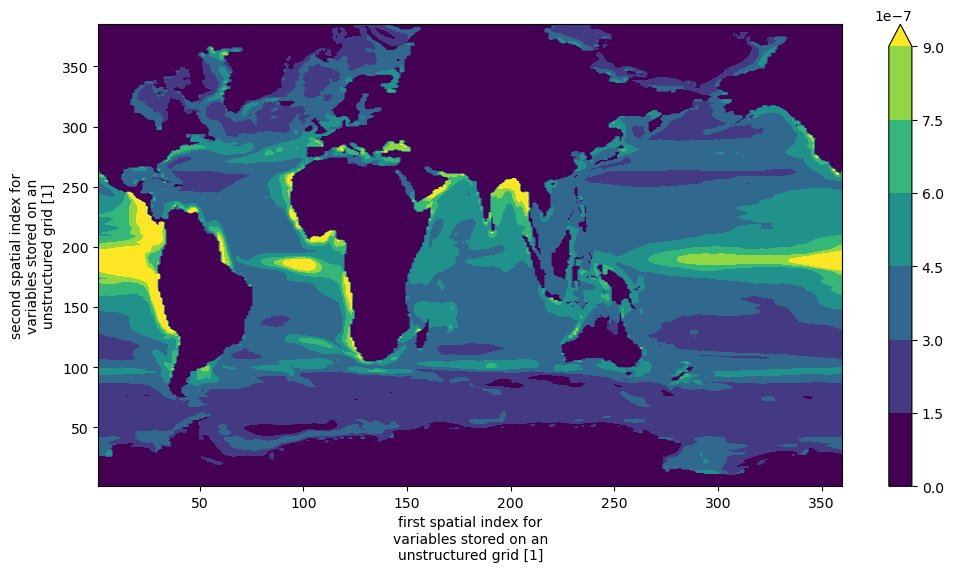

In [56]:
av=aa.mean('year')
plt.figure(figsize=(12,6))
av.plot.contourf(cmap='viridis',robust=True)
#av